<a href="https://colab.research.google.com/github/AbdullahHassan176/FinGanFlow/blob/main/GAN%20for%20JPMorgan%20EQ%20Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install numpy matplotlib yfinance
import numpy as np
import yfinance as yf

In [3]:
def download_stock_data(ticker, start_date, end_date):
    """
    Download historical stock price data for a given ticker symbol and date range.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data


def preprocess_data(data):
    """
    Preprocess the stock price data by normalizing the values between 0 and 1.
    """
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

In [4]:
# Download stock price data
ticker = "JPM"
start_date = "2010-01-01"
end_date = "2023-08-31"
data = download_stock_data(ticker, start_date, end_date)

# Preprocess data
normalized_data, min_val, max_val = preprocess_data(data["Close"].values)

[*********************100%***********************]  1 of 1 completed


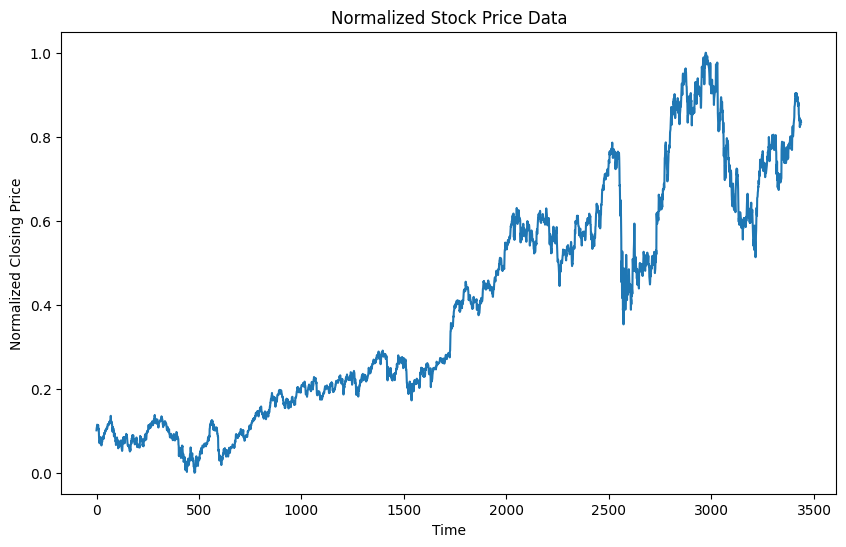

In [5]:
import matplotlib.pyplot as plt

# Plot Normalized Data
plt.figure(figsize=(10, 6))
plt.plot(normalized_data)
plt.xlabel("Time")
plt.ylabel("Normalized Closing Price")
plt.title("Normalized Stock Price Data")

plt.show()

In [7]:
# Building the Generator Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

def build_generator(input_dim, output_dim):
    """
    Build the generator network.
    """
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(output_dim, activation="tanh"))
    return model

In [8]:
input_dim = 100
output_dim = 1 # Close prices
generator = build_generator(input_dim, output_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
# Building the Discriminator Network
def build_discriminator(input_dim):
    """
    Build the discriminator network.
    """
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [10]:
discriminator = build_discriminator(output_dim)

In [11]:
# Training the GAN
from keras.optimizers import Adam

def train_gan(generator, discriminator, combined, X_train, epochs, batch_size, min_val, max_val):
    """
    Train the GAN.
    """
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]

        # Generate a batch of synthetic data
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        synthetic_data = generator.predict(noise)

        # Denormalize the synthetic data
        synthetic_data = synthetic_data * (max_val - min_val) + min_val

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(synthetic_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Generate a batch of noise vectors
        noise = np.random.normal(0, 1, (batch_size, input_dim))

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss[0]} | G loss: {g_loss}")

# Set hyperparameters
epochs = 1000
batch_size = 32

# Build the combined GAN model
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])
discriminator.trainable = False
combined = Sequential([generator, discriminator])
combined.compile(loss="binary_crossentropy", optimizer=Adam())

In [ ]:
# Reshape the data for training
X_train = normalized_data.reshape(-1, output_dim)

# Train the GAN
train_gan(generator, discriminator, combined, X_train, epochs, batch_size, min_val, max_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/1000 | D loss: 0.7873845100402832 | G loss: [array(0.89171785, dtype=float32), array(0.89171785, dtype=float32), array(0.6875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 2/1000 | D loss: 1.5174168348312378 | G loss: [array(2.2129035, dtype=float32), array(2.2129035, dtype=float32), array(0.609375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 3/1000 | D loss: 2.519355058670044 | G loss: [array(3.1318467, dtype=float32), array(3.1318467, dtype=float32), array(0.5885417, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 4/1000 | D loss: 3.159745931625366 | G loss: [array(3.53769, dtype=float32), array(3.53769, dtype=float32), array(0.57421875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 5/1000 | D loss: 3.469848155975342 | G loss: [array(3.7199008, dtype=float32), array(3.7199008, dtype=float32), array(0.578125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 6/1000 | D loss: 3.747361660003662 | G loss: [array(4.050673, dtype=float32), array(4.050673, dtype=float32), array(0.5625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 7/1000 | D loss: 4.010641098022461 | G loss: [array(4.2300

In [ ]:
# Generate synthetic data
num_samples = 1000
noise = np.random.normal(0, 1, (num_samples, input_dim))
synthetic_data = generator.predict(noise)

# Denormalize the real data
normalized_data = normalized_data * (max_val - min_val) + min_val

# Denormalize the synthetic data
synthetic_data = synthetic_data * (max_val - min_val) + min_val

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_data[-1000:], label="Real Data")
plt.plot(synthetic_data, label="Synthetic Data")
plt.xlabel("Time")
plt.ylabel("Normalized Closing Price")
plt.title("Real vs Synthetic Stock Price Data")
plt.legend()

plt.show()

In [ ]:
real_mean = np.mean(normalized_data[-1000:])
real_std = np.std(normalized_data[-1000:])

synthetic_mean = np.mean(synthetic_data)
synthetic_std = np.std(synthetic_data)

print("Real Data:")
print(f"Mean: {real_mean}")
print(f"Standard Deviation: {real_std}")
print()
print("Synthetic Data:")
print(f"Mean: {synthetic_mean}")
print(f"Standard Deviation: {synthetic_std}")